# Reconhecimento de Imagens usando Tensorflow puro

## Exemplo reconhecimento  de espécies de flores

Este exemplo lê um diretório de imagens, cria um vetor de features e inclui um tag de identificação.

Cada diretório pode comnter qualquer numero de imagens, no entanto, é obrigatório que cada diretório possua apenas uma categoria de imagem.

In [1]:
# Load libs
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from time import perf_counter

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.3.0'

In [2]:
# Set main images directory
data_repo = "/data/dataset/flower_photos/"

TRAIN_SAMPLE = 0.8
TEST_SAMPLE = 0.2
BATCH_SIZE = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=8

# Set base directory (where are all flower's directories)
data_dir = pathlib.Path(data_repo)
print(data_dir)

/data/dataset/flower_photos


## Bibliotecas úteis

In [3]:
# Some usefull libs to read and prepare images

def get_label(file_path):
    # Get directory name,, i.e., flower specie 
    parts = tf.strings.split(file_path, '/')
    # Check file path and return label
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # Decode jpeg image
    img = tf.image.decode_jpeg(img, channels=3) #color images
    # Convert unit8 tensor to floats in the [0,1]range
    img = tf.image.convert_image_dtype(img, tf.float32) 
    # Resize the image  
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

def process_path(file_path):
    # Get label
    label = get_label(file_path)
    # Get image file and convert to tensor
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # Test if images are on cache and use it
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.show() 

## Leitura images do repositorio

In [4]:
# Count the number of flower images and set dataset size
SIZE_OF_DATASET = len(list(data_dir.glob('*/*.jpg')))

print("Number of images: ",SIZE_OF_DATASET)

Number of images:  4510


In [5]:
# Get the Class names reading directory names
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
#CLASS_NAMES = list([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['dandelion' 'daisy' 'sunflower' 'rose' 'tulip']


In [6]:
# Read all images files and set Tensor
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/data/dataset/flower_photos/daisy/14921511479_7b0a647795.jpg'
b'/data/dataset/flower_photos/tulip/14069841698_a5dff9cfd2_n.jpg'
b'/data/dataset/flower_photos/dandelion/14202166370_e989588332.jpg'
b'/data/dataset/flower_photos/rose/18464065816_88f194a890_n.jpg'
b'/data/dataset/flower_photos/tulip/6903831250_a2757fff82_m.jpg'


In [7]:
# Process images
start_time = perf_counter()

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
images_ds = prepare_for_training(labeled_ds)

In [8]:
# Split train and test sample
train_ds = images_ds.take(int(TRAIN_SAMPLE*SIZE_OF_DATASET))
test_ds = images_ds.skip(int(TEST_SAMPLE*SIZE_OF_DATASET))

train_images, train_labels = next(iter(train_ds))
test_images, test_labels = next(iter(test_ds))

print("train image: ", tf.size(train_images))
print("train labels: ", tf.size(train_labels))

time_ip = perf_counter() - start_time
tf.print("Image processing time:", time_ip)

train image:  tf.Tensor(1505280, shape=(), dtype=int32)
train labels:  tf.Tensor(50, shape=(), dtype=int32)
Image processing time: 2.781058091990417


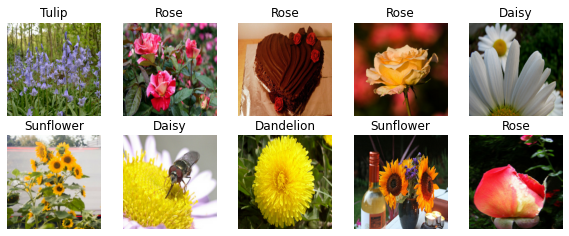

In [9]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Create Convolutional Neural Network (CNN) Model

## Modelo Simples 

In [10]:
start_time = perf_counter()

model = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(5, activation='relu'),
    layers.Dense(5)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [11]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/8
1/1 [==============================] - 0s 171ms/step - loss: 1.6319 - accuracy: 0.2000 - val_loss: 2.0885 - val_accuracy: 0.1000
Epoch 2/8
1/1 [==============================] - 0s 45ms/step - loss: 1.7002 - accuracy: 0.2000 - val_loss: 1.6061 - val_accuracy: 0.1000
Epoch 3/8
1/1 [==============================] - 0s 53ms/step - loss: 1.4943 - accuracy: 0.2000 - val_loss: 1.5721 - val_accuracy: 0.1000
Epoch 4/8
1/1 [==============================] - 0s 49ms/step - loss: 1.4665 - accuracy: 0.2000 - val_loss: 1.6211 - val_accuracy: 0.1000
Epoch 5/8
1/1 [==============================] - 0s 44ms/step - loss: 1.4060 - accuracy: 0.2000 - val_loss: 1.7312 - val_accuracy: 0.1000
Epoch 6/8
1/1 [==============================] - 0s 48ms/step - loss: 1.3600 - accuracy: 0.2000 - val_loss: 1.8943 - val_accuracy: 0.1000
Epoch 7/8
1/1 [==============================] - 0s 47ms/step - loss: 1.3551 - accuracy: 0.2000 - val_loss: 2.0348 - val_accuracy: 0.1000
Epoch 8/8
1/1 [==================

### Evaluating the Simple CNN Model Performance

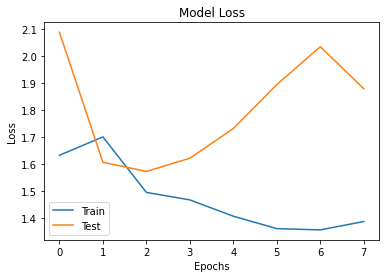

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

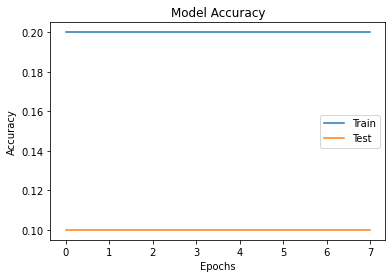

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [14]:
train_loss_sm, train_acc_sm = model.evaluate(train_images, train_labels, verbose=2)
test_loss_sm, test_acc_sm = model.evaluate(test_images, test_labels, verbose=2)
time_sm = perf_counter() - start_time
print(time_sm)

1/1 - 0s - loss: 1.3101 - accuracy: 0.2000
1/1 - 0s - loss: 1.8789 - accuracy: 0.1000
2.6829764079884626


## Modelo Complexo 

In [15]:
start_time = perf_counter()

model = models.Sequential([
# layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_1'),
    layers.Conv2D(32, (3,3), activation='relu', name='conv_2'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_1'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'),
    layers.Conv2D(64, (3,3), activation='relu', name='conv_4'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_2'),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'),
    layers.Conv2D(128, (3,3), activation='relu', name='conv_6'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_3'),
    layers.Flatten(),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', name='dense_2'),
    layers.Dense(len(CLASS_NAMES), name='output'),
    layers.Activation('softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 222, 222, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 111, 111, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 109, 109, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 54, 54, 64)       

In [16]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/8
1/1 [==============================] - 0s 250ms/step - loss: 1.6107 - accuracy: 0.1000 - val_loss: 1.5912 - val_accuracy: 0.2000
Epoch 2/8
1/1 [==============================] - 0s 105ms/step - loss: 1.5650 - accuracy: 0.4000 - val_loss: 1.6726 - val_accuracy: 0.2000
Epoch 3/8
1/1 [==============================] - 0s 118ms/step - loss: 1.4972 - accuracy: 0.4000 - val_loss: 1.6765 - val_accuracy: 0.2000
Epoch 4/8
1/1 [==============================] - 0s 156ms/step - loss: 1.4742 - accuracy: 0.4000 - val_loss: 1.6395 - val_accuracy: 0.2000
Epoch 5/8
1/1 [==============================] - 0s 112ms/step - loss: 1.4554 - accuracy: 0.4000 - val_loss: 1.6263 - val_accuracy: 0.2000
Epoch 6/8
1/1 [==============================] - 0s 116ms/step - loss: 1.2973 - accuracy: 0.6000 - val_loss: 1.5777 - val_accuracy: 0.3000
Epoch 7/8
1/1 [==============================] - 0s 123ms/step - loss: 1.2534 - accuracy: 0.7000 - val_loss: 1.6434 - val_accuracy: 0.3000
Epoch 8/8
1/1 [============

### Evaluating the Complex CNN Model Performance

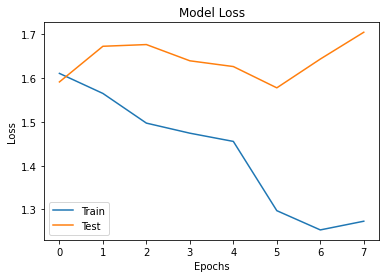

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

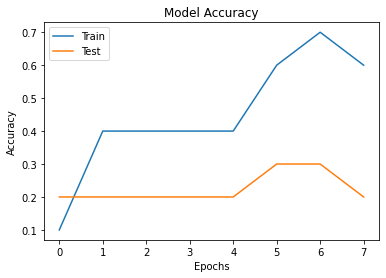

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [19]:
train_loss_cm, train_acc_cm = model.evaluate(train_images, train_labels, verbose=2)
test_loss_cm, test_acc_cm = model.evaluate(test_images, test_labels, verbose=2)
time_cm = perf_counter() - start_time
print(time_cm)

1/1 - 0s - loss: 1.3176 - accuracy: 0.6000
1/1 - 0s - loss: 1.7047 - accuracy: 0.2000
8.773473901004763


## Modelo VGG19

In [20]:
start_time = perf_counter()

pre_trained_model = VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), include_top=False, weights="imagenet")

#pre_trained_model.trainable = False
for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

# creating the final model  
model = models.Sequential([
    pre_trained_model,
    layers.MaxPool2D((2,2) , strides = 2),
    layers.Flatten(),
    layers.Dense(len(CLASS_NAMES) , activation='softmax')
])

#model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

#model.compile(optimizer='adam',
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])


model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [21]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/8
1/1 [==============================] - 1s 771ms/step - loss: 1.6850 - accuracy: 0.0000e+00 - val_loss: 1.5035 - val_accuracy: 0.4000
Epoch 2/8
1/1 [==============================] - 1s 563ms/step - loss: 1.1346 - accuracy: 0.7000 - val_loss: 1.7044 - val_accuracy: 0.2000
Epoch 3/8
1/1 [==============================] - 1s 557ms/step - loss: 1.1781 - accuracy: 0.8000 - val_loss: 1.6701 - val_accuracy: 0.2000
Epoch 4/8
1/1 [==============================] - 1s 592ms/step - loss: 0.9121 - accuracy: 1.0000 - val_loss: 1.7833 - val_accuracy: 0.1000
Epoch 5/8
1/1 [==============================] - 1s 565ms/step - loss: 1.0157 - accuracy: 0.9000 - val_loss: 1.5545 - val_accuracy: 0.3000
Epoch 6/8
1/1 [==============================] - 1s 575ms/step - loss: 0.9049 - accuracy: 1.0000 - val_loss: 1.5507 - val_accuracy: 0.3000
Epoch 7/8
1/1 [==============================] - 1s 557ms/step - loss: 0.9048 - accuracy: 1.0000 - val_loss: 1.5716 - val_accuracy: 0.3000
Epoch 8/8
1/1 [========

### Evaluating the VGG19 CNN Model Performance

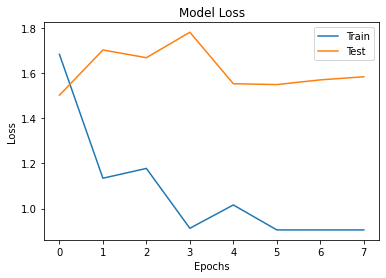

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

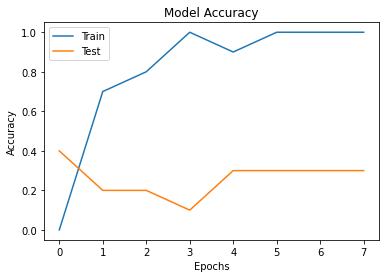

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [24]:
train_loss_vg, train_acc_vg = model.evaluate(train_images, train_labels, verbose=2)
test_loss_vg, test_acc_vg = model.evaluate(test_images, test_labels, verbose=2)
time_vg = perf_counter() - start_time
print(time_vg)

1/1 - 0s - loss: 0.9050 - accuracy: 1.0000
1/1 - 0s - loss: 1.5854 - accuracy: 0.3000
13.03227345700725


## Modelo ResNet

In [25]:
start_time = perf_counter()

pre_trained_model = ResNet50(include_top=False, pooling='avg')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)             

In [26]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/8
1/1 [==============================] - 1s 923ms/step - loss: 1.6030 - accuracy: 0.2000 - val_loss: 1.6542 - val_accuracy: 0.1000
Epoch 2/8
1/1 [==============================] - 0s 193ms/step - loss: 1.0482 - accuracy: 0.9000 - val_loss: 1.6322 - val_accuracy: 0.1000
Epoch 3/8
1/1 [==============================] - 0s 202ms/step - loss: 1.0136 - accuracy: 0.9000 - val_loss: 1.6238 - val_accuracy: 0.1000
Epoch 4/8
1/1 [==============================] - 0s 205ms/step - loss: 1.0044 - accuracy: 0.9000 - val_loss: 1.6163 - val_accuracy: 0.1000
Epoch 5/8
1/1 [==============================] - 0s 195ms/step - loss: 1.0048 - accuracy: 0.9000 - val_loss: 1.6078 - val_accuracy: 0.2000
Epoch 6/8
1/1 [==============================] - 0s 198ms/step - loss: 1.0049 - accuracy: 0.9000 - val_loss: 1.5997 - val_accuracy: 0.2000
Epoch 7/8
1/1 [==============================] - 0s 196ms/step - loss: 1.0049 - accuracy: 0.9000 - val_loss: 1.5914 - val_accuracy: 0.3000
Epoch 8/8
1/1 [============

### Evaluating the Resnet CNN Model Performance

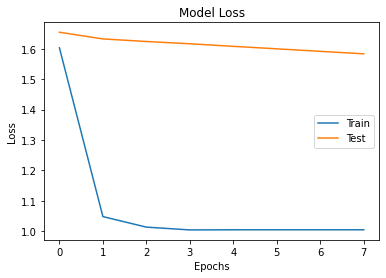

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

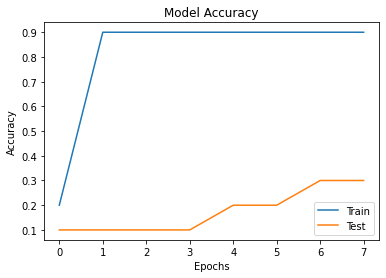

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [29]:
train_loss_rn, train_acc_rn = model.evaluate(train_images, train_labels, verbose=2)
test_loss_rn, test_acc_rn = model.evaluate(test_images, test_labels, verbose=2)
time_rn = perf_counter() - start_time
print(time_rn)

1/1 - 0s - loss: 1.5946 - accuracy: 0.3000
1/1 - 0s - loss: 1.5833 - accuracy: 0.3000
10.961851025000215


## Modelo InceptionV3

In [30]:
start_time = perf_counter()

pre_trained_model = InceptionV3(include_top=False, weights="imagenet", pooling='avg', classifier_activation='softmax')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_98 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_99 (Batc (None, 1024)             

### Evaluating the InceptionV3 CNN Model Performance

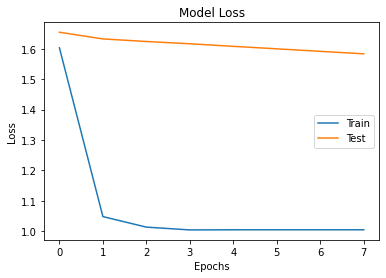

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

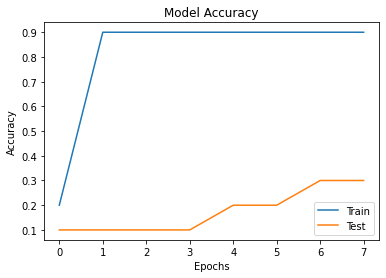

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [33]:
train_loss_iv, train_acc_iv = model.evaluate(train_images, train_labels, verbose=2)
test_loss_iv, test_acc_iv = model.evaluate(test_images, test_labels, verbose=2)
time_iv = perf_counter() - start_time
print(time_iv)

1/1 - 0s - loss: 1.5717 - accuracy: 0.3000
1/1 - 0s - loss: 1.6184 - accuracy: 0.1000
6.3020832180045545


## Sumary  

In [34]:
print("===========================================================================")
print("===============  Compare CNN Algorithms Acurancy and Time =================")
print()
print("   Dataset size = ",SIZE_OF_DATASET,"   Train sample = ",TRAIN_SAMPLE*100,"%  Test sample = ",TEST_SAMPLE*100,"%")
print("   Image size: (%d,%d)   Batch size = %d         Epochs = %d        " % (IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS))
print()
print("Processing images:                                          time = %3.1f s" % (time_ip))
print("Simple Model:         train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_sm, test_acc_sm, time_sm))
print("Complex Model:        train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_cm, test_acc_cm, time_cm))
print("VGG19:                train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_vg, test_acc_vg, time_vg))
print("ResNet50:             train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_rn, test_acc_rn, time_rn))
print("InceptionV3:          train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_iv, test_acc_iv, time_iv))
print("===========================================================================")

===============  Compare CNN Algorithms Acurancy and Time =================

   Dataset size =  4510    Train sample =  80.0 %  Test sample =  20.0 %
   Image size: (224,224)   Batch size = 10         Epochs = 8        

Processing images:                                          time = 2.8 s
Simple Model:         train_acc = 0.20    test_acc = 0.10   time = 2.7 s
Complex Model:        train_acc = 0.60    test_acc = 0.20   time = 8.8 s
VGG19:                train_acc = 1.00    test_acc = 0.30   time = 13.0 s
ResNet50:             train_acc = 0.30    test_acc = 0.30   time = 11.0 s
InceptionV3:          train_acc = 0.30    test_acc = 0.10   time = 6.3 s
